In [3]:
import re
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt # for data visualization
import string
import math
import random
import re # regular expression library; for tokenization of words
from collections import Counter # collections library; counter: dict subclass for counting hashable objects
from pomocne_soubory.utils_pos import get_word_tag, preprocess
from pomocne_soubory.utils2 import get_dict

import emoji
import pickle

import nltk # import NLTK to handle simple NL tasks like tokenization.
from nltk.tokenize import word_tokenize            
nltk.download("punkt")
from nltk.util import ngrams



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michaelmateju/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
!pip3 install 'sacrebleu'           # install the sacrebleu package.
import sacrebleu                    # import sacrebleu in order compute the BLEU score.

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Setting this env variable prevents TF warnings from showing up

import tensorflow as tf
import tensorflow_text as tf_text
from pomocne_soubory.utils_nmt_attention import (sentences, train_data, val_data, english_vectorizer, portuguese_vectorizer, masked_loss, masked_acc, tokens_to_text)

# 2. Natural Language Processing with Probabilistic Models

## 2.1 Machine Translation

Jeden z prvnich modelu, ktery pouzival Attention mechanismus, je model pro preklad textu. V tomto pripade se jedna o 
preklad z anglictiny do francouzstiny. Model se nazyva Seq2Seq model, se kterym prisel v roce 2014 Ilya Sutskever ze spolecnosti Google.
Model se sklada z dvou hlavnich casti: Encoder a Decoder. Encoder prevede vstupni
sekvenci na vektor fixni delky, tzv. embedding dimension, ktery reprezentuje vstupni sekvenci. 
Decoder prevede tento vektor na vystupni sekvenci, opet ruzne delky. V modelu se pouzivaji dva typy RNN: LSTM a GRU, 
abychom se vyhnuli problemu s vanishing/exploding gradientem. 

Encoder vetsinou ma embedding layer, ktery prevede slova na vektory, RNN, ktery prevede vektory na jeden vektor, 
ktery zachycuje vyznam vstupni sekvence. 

![Seq2Seq](./pomocne_soubory/seq2seq_1.png)

Decoder ma take embedding layer, ktery prevede slova na vektory, RNN, ktery prevede vektor na sekvenci vystupnich 
slov. Prvni slovo je vzdy <start>, ktere se prevede na vektor a ten se pouzije jako vstup do RNN. RNN pak vygeneruje
dalsi slovo, ktere se pouzije jako vstup do dalsi iterace. Tento proces se opakuje, dokud model nevygeneruje <end>
slovo nebo nedosahne maximalni delky vystupni sekvence.

![Seq2Seq](./pomocne_soubory/seq2seq_2.png)

Hlavni nevyhodou modelu je tzv. information bottleneck, kdy je cela informace z vstupni sekvence zakodovana do jednoho
vektoru fixni delky. Pro velmi dlohe vstupni sekvence muze byt tento vektor prilis kratki a neobsahovat dostatek 
informaci. Resenim by mohlo byt pouzit vsechny vstupni hidden states z encoderu do decoderu, ale to zase vede k 
pretizeni pameti a vypoctu. Proto vznikl Attention mechanismus, ktery umoznuje modelu se zamirit na ruzne casti
vstupni sekvence pri generovani vystupni sekvence.

![Seq2Seq](./pomocne_soubory/seq2seq_3.png)

Attention mechasmus zkombinuje vsechny hidden states z encoderu a vytvori novy vektor, ktery se nazyva context vector. 
Zkombinuje = affini soucet hidden states z encoderu a vahy, ktere urcuji, jak moc se ma brat v potaz dany hidden 
state. Vahy zavisi na aktualnim hidden state z decoderu a vsechny hidden states z encoderu.

![Seq2Seq](./pomocne_soubory/seq2seq_4.png)

Vahy se napocitavaji pri treniniku modelu. 

![Seq2Seq](./pomocne_soubory/seq2seq_5.png)

### LAB: Basic Attention

In [5]:
def softmax(x, axis=0):
    """ Calculate softmax function for an array x along specified axis
    
        axis=0 calculates softmax across rows which means each column sums to 1 
        axis=1 calculates softmax across columns which means each row sums to 1
    """
    return np.exp(x) / np.expand_dims(np.sum(np.exp(x), axis=axis), axis)

1: Calculating alignment scores

The first step is to calculate the alignment scores. This is a measure of similarity between the decoder hidden state and each encoder hidden state. From the paper, this operation looks like

$$
\large e_{ij} = v_a^\top \tanh{\left(W_a s_{i-1} + U_a h_j\right)}
$$

where $W_a \in \mathbb{R}^{n\times m}$, $U_a \in \mathbb{R}^{n \times m}$, and $v_a \in \mathbb{R}^m$
are the weight matrices and $n$ is the hidden state size. In practice, this is implemented as a feedforward neural network with two layers, where $m$ is the size of the layers in the alignment network. 

Here $h_j$ are the encoder hidden states for each input step $j$ and $s_{i - 1}$ is the decoder hidden state of the previous step. The first layer corresponds to $W_a$ and $U_a$, while the second layer corresponds to $v_a$.

To implement this, first concatenate the encoder and decoder hidden states to produce an array with size $K \times 2n$ where $K$ is the number of encoder states/steps. For this, use `np.concatenate` ([docs](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html)). Note that there is only one decoder state so you'll need to reshape it to successfully concatenate the arrays. The easiest way is to use `decoder_state.repeat` ([docs](https://numpy.org/doc/stable/reference/generated/numpy.repeat.html#numpy.repeat)) to match the hidden state array size.

Then, apply the first layer as a matrix multiplication between the weights and the concatenated input. Use the tanh function to get the activations. Finally, compute the matrix multiplication of the second layer weights and the activations. This returns the alignment scores.

In [1]:
hidden_size = 16
attention_size = 10
input_length = 5

np.random.seed(42)

# Synthetic vectors used to test
encoder_states = np.random.randn(input_length, hidden_size)
decoder_state = np.random.randn(1, hidden_size)

# Weights for the neural network, these are typically learned through training
# Use these in the alignment function below as the layer weights
layer_1 = np.random.randn(2 * hidden_size, attention_size)
layer_2 = np.random.randn(attention_size, 1)

# Implement this function. Replace None with your code. Solution at the bottom of the notebook
def alignment(encoder_states, decoder_state):
    # First, concatenate the encoder states and the decoder state
    inputs = np.concatenate((encoder_states, decoder_state.repeat(input_length, axis=0)), axis=1)
    assert inputs.shape == (input_length, 2 * hidden_size)
    
    # Matrix multiplication of the concatenated inputs and layer_1, with tanh activation
    activations = np.tanh(np.matmul(inputs, layer_1))
    assert activations.shape == (input_length, attention_size)
    
    # Matrix multiplication of the activations with layer_2. Remember that you don't need tanh here
    scores = np.matmul(activations, layer_2)
    assert scores.shape == (input_length, 1)
    
    return scores

NameError: name 'np' is not defined

In [ ]:
# Run this to test your alignment function
scores = alignment(encoder_states, decoder_state)
print(scores)

2: Turning alignment into weights

The next step is to calculate the weights from the alignment scores. These weights determine the encoder outputs that are the most important for the decoder output. These weights should be between 0 and 1. You can use the softmax function (which is already implemented above) to get these weights from the attention scores. Pass the attention scores vector to the softmax function to get the weights. Mathematically,

$$
\large \alpha_{ij} = \frac{\exp{\left(e_{ij}\right)}}{\sum_{k=1}^K \exp{\left(e_{ik}\right)}}
$$



3: Weight the encoder output vectors and sum

The weights tell you the importance of each input word with respect to the decoder state. In this step, you use the weights to modulate the magnitude of the encoder vectors. Words with little importance will be scaled down relative to important words. Multiply each encoder vector by its respective weight to get the alignment vectors, then sum up the weighted alignment vectors to get the context vector. Mathematically,

$$
\large c_i = \sum_{j=1}^K\alpha_{ij} h_{j}
$$

Implement these steps in the `attention` function below.

In [5]:
# Implement this function. Replace None with your code.
def attention(encoder_states, decoder_state):
    """ Example function that calculates attention, returns the context vector 
    
        Arguments:
        encoder_vectors: NxM numpy array, where N is the number of vectors and M is the vector length
        decoder_vector: 1xM numpy array, M is the vector length, much be the same M as encoder_vectors
    """ 
    
    # First, calculate the alignment scores
    scores = alignment(encoder_states, decoder_state)
    
    # Then take the softmax of the alignment scores to get a weight distribution
    weights = softmax(scores)
    
    # Multiply each encoder state by its respective weight
    weighted_scores = encoder_states * weights
    
    # Sum up weighted alignment vectors to get the context vector and return it
    context = np.sum(weighted_scores, axis=0)
    return context

context_vector = attention(encoder_states, decoder_state)
print(context_vector)

[-0.63514569  0.04917298 -0.43930867 -0.9268003   1.01903919 -0.43181409
  0.13365099 -0.84746874 -0.37572203  0.18279832 -0.90452701  0.17872958
 -0.58015282 -0.58294027 -0.75457577  1.32985756]


## Attention mechanism

Pro pochopeni jak funguje attention mechanismus viz tenhle post: https://jalammar.github.io/illustrated-transformer/

### LAB: Attention Mechanism - Scaled dot-product attention

In [6]:
# Load the word2int dictionaries
with open("./pomocne_soubory/word2int_en.pkl", "rb") as f:
    en_words = pickle.load(f)
    
with open("./pomocne_soubory/word2int_fr.pkl", "rb") as f:
    fr_words = pickle.load(f)

# Load the word embeddings
en_embeddings = np.load("./pomocne_soubory/embeddings_en.npz")["embeddings"]
fr_embeddings = np.load("./pomocne_soubory/embeddings_fr.npz")["embeddings"]

NameError: name 'pickle' is not defined

In [7]:
# Define some helper functions

def tokenize(sentence, token_mapping):
    tokenized = []
    
    for word in sentence.lower().split(" "):
        try:
            tokenized.append(token_mapping[word])
        except KeyError:
            # Using -1 to indicate an unknown word
            tokenized.append(-1)
        
    return tokenized


def embed(tokens, embeddings):
    embed_size = embeddings.shape[1]
    
    output = np.zeros((len(tokens), embed_size))
    for i, token in enumerate(tokens):
        if token == -1:
            output[i] = np.zeros((1, embed_size))
        else:
            output[i] = embeddings[token]
            
    return output

The scaled-dot product attention consists of two matrix multiplications and a softmax scaling as shown in the diagram below from [Vaswani, et al. (2017)](https://arxiv.org/abs/1706.03762). It takes three input matrices, the queries, keys, and values.

![scaled-dot product attention diagram](./pomocne_soubory/attention.png)

Mathematically, this is expressed as:
$$ 
\large \mathrm{Attention}\left(Q, K, V\right) = \mathrm{softmax}\left(\frac{QK^{\top}}{\sqrt{d_k}}\right)V
$$

where $Q$, $K$, and $V$ are the queries, keys, and values matrices respectively, and $d_k$ is the dimension of the keys. In practice, Q, K, and V all have the same dimensions. This form of attention is faster and more space-efficient than what you implemented before since it consists of only matrix multiplications instead of a learned feed-forward layer.

Conceptually, the first matrix multiplication is a measure of the similarity between the queries and the keys. This is transformed into weights using the softmax function. These weights are then applied to the values with the second matrix multiplication resulting in output attention vectors. Typically, decoder states are used as the queries while encoder states are the keys and values.

Exercise 1

Implement the softmax function with Numpy and use it to calculate the weights from the queries and keys. Assume the queries and keys are 2D arrays (matrices). Note that since the dot-product of Q and K will be a matrix, you'll need to calculate softmax over a specific axis. See the end of the notebook for solutions.

In [9]:
def softmax(x, axis=0):    
    """ Calculate softmax function for an array x

        axis=0 calculates softmax across rows which means each column sums to 1 
        axis=1 calculates softmax across columns which means each row sums to 1
    """
    # Replace pass with your code.
    y = np.exp(x) 
    return y / np.expand_dims(np.sum(y, axis=axis), axis)

def calculate_weights(queries, keys):
    """ Calculate the weights for scaled dot-product attention"""
    #Replace None with your code.
    dot = np.matmul(queries, keys.T)/np.sqrt(keys.shape[1])
    weights = softmax(dot, axis=1)
    
    assert weights.sum(axis=1)[0] == 1, "Each row in weights must sum to 1"
    
    #Replace pass with your code.
    return weights

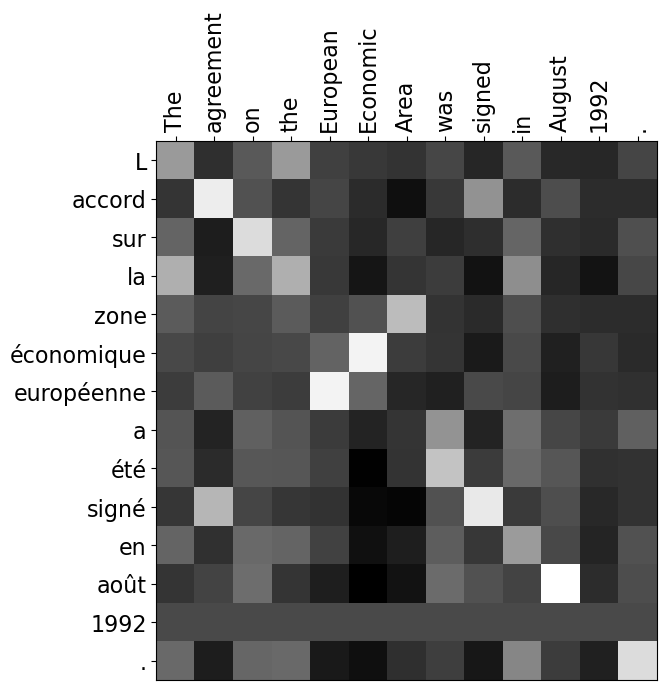

In [10]:
# Tokenize example sentences in English and French, then get their embeddings
sentence_en = "The agreement on the European Economic Area was signed in August 1992 ."
tokenized_en = tokenize(sentence_en, en_words)
embedded_en = embed(tokenized_en, en_embeddings)

sentence_fr = "L accord sur la zone économique européenne a été signé en août 1992 ."
tokenized_fr = tokenize(sentence_fr, fr_words)
embedded_fr = embed(tokenized_fr, fr_embeddings)

# These weights indicate alignment between words in English and French
alignment = calculate_weights(embedded_fr, embedded_en)

# Visualize weights to check for alignment
fig, ax = plt.subplots(figsize=(7,7))
ax.imshow(alignment, cmap='gray')
ax.xaxis.tick_top()
ax.set_xticks(np.arange(alignment.shape[1]))
ax.set_xticklabels(sentence_en.split(" "), rotation=90, size=16);
ax.set_yticks(np.arange(alignment.shape[0]));
ax.set_yticklabels(sentence_fr.split(" "), size=16);

In [14]:
def attention_qkv(queries, keys, values):
    """ Calculate scaled dot-product attention from queries, keys, and values matrices """
    weights = calculate_weights(queries, keys)
    return np.matmul(weights, values)


attention_qkv_result = attention_qkv(embedded_fr, embedded_en, embedded_en)

print(f"The shape of the attention_qkv function is{attention_qkv_result.shape}")
print(f"Some elements of the attention_qkv function are\n{attention_qkv_result[0:2,:10]}")

The shape of the attention_qkv function is(14, 300)
Some elements of the attention_qkv function are
[[-0.04039161 -0.00275749  0.00389873  0.04842744 -0.02472726  0.01435613
  -0.00370253 -0.0619686  -0.00206159  0.01615228]
 [-0.04083253 -0.00245985  0.00409068  0.04830341 -0.02479128  0.01447497
  -0.00355203 -0.06196036 -0.00241327  0.01582606]]


## 2.2 Setup for machine translation

Data preprocessing bude vysvelen v dalsim LABu

**Teacher Forcing** - je technika, ktera se pouziva pri trenovani modelu. V kazdem kroku modelu se pouzije skutecne 
slovo z vystupni sekvence, nikoli predikovane slovo. Tato technika zrychluje trenovani modelu, ale muze zpusobit, ze 
model se bude chovat jinak pri trenovani a pri predikci. 

Existuje varianta, ktera se jmenuje **Curriculum Learning**, ktera
pouziva Teacher Forcing v case zacina vice a vice pouzivat predikovane slovo misto skutecneho slova.

K teto technice existuje i opacna technika, ktera se nazyva **Scheduled Sampling**, ktera nahrazuje skutecne slovo s 
predikovanym slovem s urcitou pravdepodobnosti.


V LABu bude varianta modelu NMT (Neural Machine Translation), ktera pouziva Attention mechanismus. Model bude prekladat
text z anglictiny do francouzstiny. Varianta spociva v tom, ze bude obsahovat encoder a pre-attention decoder, 
spolecne se pak spoji v attention mechanismus a vysledek se pouzije v post-attention decoderu.

![scaled-dot product attention diagram](./pomocne_soubory/nmt_1.png)

![scaled-dot product attention diagram](./pomocne_soubory/nmt_2.png)

## 2.3 Machine Translation Evaluation

### BLEU Score

BLEU (Bilingual Evaluation Understudy) je metrika pro mereni kvality prekladu. Jedna se o precision metriku a 
napocitava tzv. n-gram precision. 

BLEU napocitava pocet shodnych n-gramu mezi predikovanou a skutecnou sekvenci (nebo sekvencich). Resp. jde po kazdem 
n-gramu v predikovane sekvenci a kouka se, zda-li se objevila v prekladu. Pokud ano, tak se zvysi pocet. Tj. jedna se
 opravdu o precision metriku.
Nicmene, kazdy n-gram ze skutecne sekvence se muze vyskytnout nejvyse jedenkrat v predikovane sekvenci. Tj. pocet se 
 pocita jako min(pocet vyskytu slova ve skutecne sekvenci, pocet vyskytu slova ve predikovane sekvenci).

BLEU Score se pocita jako geometricke prumer aritmetickych hodnot precisionu pro kazdy n-gram. 

Nevyhoda BLEU je, ze n-gram precision nebere v potaz poradi slov. Tj. pokud je ve skutecne sekvenci slovo na jinem
mistě nez v predikovane sekvenci, tak se to nepocita jako chyba.

### LAB: BLEU Score

$$
BLEU = BP\times\Bigl( \prod_{i=1}^{n}precision_i\Bigr)^{(1/n)}.\tag{1}
$$

2. BLEU score

2.1 Definitions and formulas

You have seen how to calculate the BLEU score in this week's lectures. Formally, you can express the BLEU score as:
$$
BLEU = BP\times\Bigl( \prod_{i=1}^{n}precision_i \Bigr)^{(1/n)}.\tag{1}
$$

The BLEU score depends on the $BP$, which stands for Brevity Penalty, and the weighted geometric mean precision for different lengths of n-grams, both of which are described below. The product runs from $i=1$ to $i=n$ to account for 1-grams to n-grams and the exponent of $1/n$ is there to calculate the geometrical average. In this notebook, you will use $n=4$

The **Brevity Penalty** is defined as an exponential decay:

$$BP = min\Bigl(1, e^{(1-({len(ref)}/{len(cand)}))}\Bigr),\tag{2}$$

where ${len(ref)}$ and ${len(cand)}$ refer to the length or count of words in the reference and candidate translations. The brevity penalty helps to handle very short translations. 

The **precision** is defined as :

$$precision_i = \frac {\sum_{s_i \in{cand}}min\Bigl(C(s_i, cand), C(s_i, ref)\Bigr)}{\sum_{s_i \in{cand}} C(s_i, cand)}.\tag{3}$$

The sum goes over all the i-grams $s_i$ in the candidate sentence $cand$. $C(s_i, cand)$ and $C(s_i, ref)$ are the counts of the i-grams in the candidate and reference sentences respectively. So the sum counts all the n-grams in the candidate sentence that also appear in the reference sentence, but only counts them as many times as they appear in the reference sentence and not more. This is then divided by the total number of i-grams in the candidate sentence.

2.2 Visualizing the BLEU score

Brevity Penalty:

The brevity penalty penalizes generated translations that are shorter than the reference sentence. It compensates for the fact that the BLEU score has no recall term.

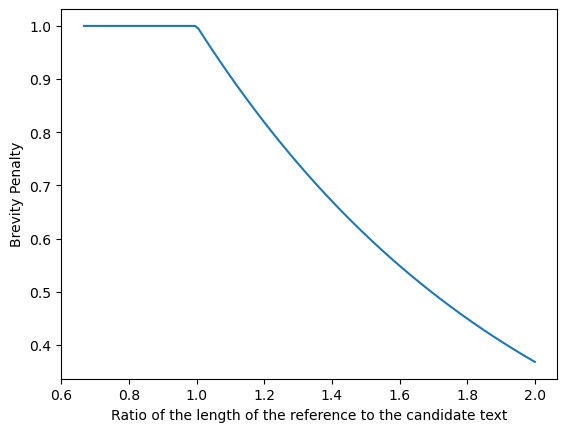

In [17]:
reference_length = 1
candidate_length = np.linspace(1.5, 0.5, 100)

length_ratio = reference_length / candidate_length
BP = np.minimum(1, np.exp(1 - length_ratio))

# Plot the data
fig, ax = plt.subplots(1)
lines = ax.plot(length_ratio, BP)
ax.set(
    xlabel="Ratio of the length of the reference to the candidate text",
    ylabel="Brevity Penalty",
)
plt.show()

N-Gram Precision:

The n-gram precision counts how many n-grams (in your case unigrams, bigrams, trigrams, and four-grams for i =1 , ... , 4) match their n-gram counterpart in the reference translations. This term acts as a precision metric. Unigrams account for adequacy while longer n-grams account for fluency of the translation. To avoid overcounting, the n-gram counts are clipped to the maximal n-gram count occurring in the reference ($m_{n}^{ref}$). Typically precision shows exponential decay with the degree of the n-gram.

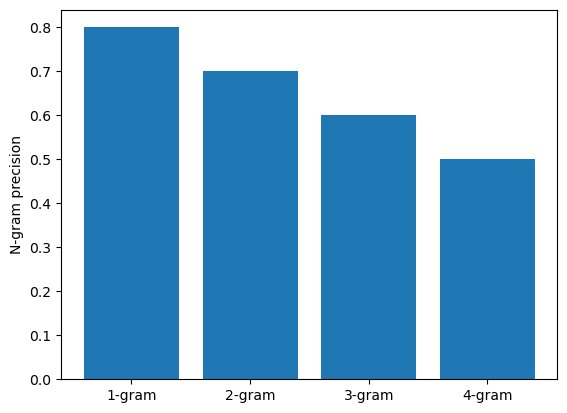

In [19]:
#Mocked dataset showing the precision for different n-grams
data = {"1-gram": 0.8, "2-gram": 0.7, "3-gram": 0.6, "4-gram": 0.5}

# Plot the datapoints defined above
fig, ax = plt.subplots(1)
bars = ax.bar(*zip(*data.items()))
ax.set(ylabel="N-gram precision")
plt.show()

N-gram BLEU score:

When the n-gram precision is normalized by the brevity penalty (BP), then the exponential decay of n-grams is almost fully compensated. The BLEU score corresponds to a geometric average of this modified n-gram precision.

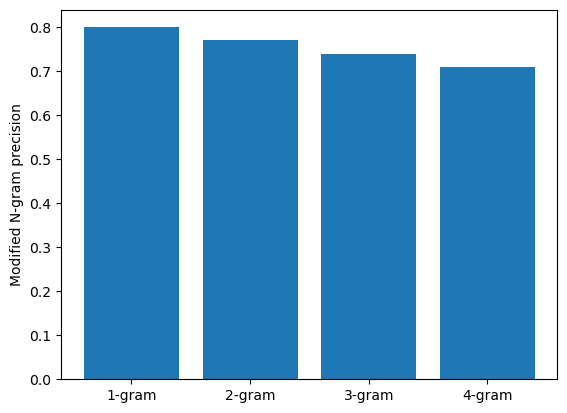

In [20]:
#Mocked dataset showing the precision multiplied by the BP for different n-grams
data = {"1-gram": 0.8, "2-gram": 0.77, "3-gram": 0.74, "4-gram": 0.71}

# Plot the datapoints defined above
fig, ax = plt.subplots(1)
bars = ax.bar(*zip(*data.items()))
ax.set(ylabel="Modified N-gram precision")
plt.show()

3. Example Calculations of the BLEU score

In this example you will have a reference sentence and 2 candidate sentences. You will tokenize all sentences using the NLTK package. Then you will compare the two candidates to the reference using BLEU score.

First you define and tokenize the sentences.

In [21]:
reference = "The NASA Opportunity rover is battling a massive dust storm on planet Mars."
candidate_1 = "The Opportunity rover is combating a big sandstorm on planet Mars."
candidate_2 = "A NASA rover is fighting a massive storm on planet Mars."

tokenized_ref = nltk.word_tokenize(reference.lower())
tokenized_cand_1 = nltk.word_tokenize(candidate_1.lower())
tokenized_cand_2 = nltk.word_tokenize(candidate_2.lower())

print(f"{reference} -> {tokenized_ref}")
print("\n")
print(f"{candidate_1} -> {tokenized_cand_1}")
print("\n")
print(f"{candidate_2} -> {tokenized_cand_2}")

The NASA Opportunity rover is battling a massive dust storm on planet Mars. -> ['the', 'nasa', 'opportunity', 'rover', 'is', 'battling', 'a', 'massive', 'dust', 'storm', 'on', 'planet', 'mars', '.']


The Opportunity rover is combating a big sandstorm on planet Mars. -> ['the', 'opportunity', 'rover', 'is', 'combating', 'a', 'big', 'sandstorm', 'on', 'planet', 'mars', '.']


A NASA rover is fighting a massive storm on planet Mars. -> ['a', 'nasa', 'rover', 'is', 'fighting', 'a', 'massive', 'storm', 'on', 'planet', 'mars', '.']


In [22]:
def brevity_penalty(candidate, reference):
    """
    Calculates the brevity penalty given the candidate and reference sentences.
    """
    reference_length = len(reference)
    candidate_length = len(candidate)

    if reference_length < candidate_length:
        BP = 1
    else:
        penalty = 1 - (reference_length / candidate_length)
        BP = np.exp(penalty)

    return BP

In [23]:
def average_clipped_precision(candidate, reference):
    """
    Calculates the precision given the candidate and reference sentences.
    """

    clipped_precision_score = []
    
    # Loop through values 1, 2, 3, 4. This is the length of n-grams
    for n_gram_length in range(1, 5):
        reference_n_gram_counts = Counter(ngrams(reference, n_gram_length))        
        candidate_n_gram_counts = Counter(ngrams(candidate, n_gram_length))                

        total_candidate_ngrams = sum(candidate_n_gram_counts.values())       
        
        for ngram in candidate_n_gram_counts: 
            # check if it is in the reference n-gram
            if ngram in reference_n_gram_counts:
                # if the count of the candidate n-gram is bigger than the corresponding
                # count in the reference n-gram, then set the count of the candidate n-gram 
                # to be equal to the reference n-gram
                
                if candidate_n_gram_counts[ngram] > reference_n_gram_counts[ngram]: 
                    candidate_n_gram_counts[ngram] = reference_n_gram_counts[ngram] # t
                                                   
            else:
                candidate_n_gram_counts[ngram] = 0 # else set the candidate n-gram equal to zero

        clipped_candidate_ngrams = sum(candidate_n_gram_counts.values())
        
        clipped_precision_score.append(clipped_candidate_ngrams / total_candidate_ngrams)
    
    # Calculate the geometric average: take the mean of elemntwise log, then exponentiate
    # This is equivalent to taking the n-th root of the product as shown in equation (1) above
    s = np.exp(np.mean(np.log(clipped_precision_score)))
    
    return s


In [24]:
def average_clipped_precision_2(candidate, reference):
    """
    Calculates the precision given the candidate and reference sentences.
    """

    clipped_precision_score = []
    
    # Loop through values 1, 2, 3, 4. This is the length of n-grams
    for n_gram_length in range(1, 5):
        reference_n_gram_counts = Counter(ngrams(reference, n_gram_length))        
        candidate_n_gram_counts = Counter(ngrams(candidate, n_gram_length))                

        total_candidate_ngrams = sum(candidate_n_gram_counts.values())       
        
        for ngram in candidate_n_gram_counts: 
            # check if it is in the reference n-gram
            candidate_n_gram_counts[ngram] = min([candidate_n_gram_counts[ngram], reference_n_gram_counts[ngram]])

        clipped_candidate_ngrams = sum(candidate_n_gram_counts.values())
        
        clipped_precision_score.append(clipped_candidate_ngrams / total_candidate_ngrams)
    
    # Calculate the geometric average: take the mean of elemntwise log, then exponentiate
    # This is equivalent to taking the n-th root of the product as shown in equation (1) above
    s = np.exp(np.mean(np.log(clipped_precision_score)))
    
    return s


In [25]:
def bleu_score(candidate, reference):
    BP = brevity_penalty(candidate, reference)    
    geometric_average_precision = average_clipped_precision_2(candidate, reference)    
    return BP * geometric_average_precision

In [26]:
result_candidate_1 = round(bleu_score(tokenized_cand_1, tokenized_ref) * 100, 1)
print(f"BLEU score of reference versus candidate 1: {result_candidate_1}")
result_candidate_2 = round(bleu_score(tokenized_cand_2, tokenized_ref) * 100, 1)
print(f"BLEU score of reference versus candidate 2: {result_candidate_2}")

BLEU score of reference versus candidate 1: 27.6
BLEU score of reference versus candidate 2: 35.3


In [27]:
result_candidate_1 = round(sacrebleu.sentence_bleu(candidate_1, [reference]).score, 1)
print(f"BLEU score of reference versus candidate 1: {result_candidate_1}")
result_candidate_2 = round(sacrebleu.sentence_bleu(candidate_2, [reference]).score, 1)
print(f"BLEU score of reference versus candidate 2: {result_candidate_2}")

BLEU score of reference versus candidate 1: 27.6
BLEU score of reference versus candidate 2: 35.3


4.  BLEU computation on a corpus

4.1 Loading Datasets for Evaluation Using the BLEU Score

In this section, you will use a simple pipeline for evaluating machine translated text. You will use English to German translations generated by [Google Translate](https://translate.google.com). There are three files you will need:

1. A source text in English. In this lab, you will use the first 1671 words of the [wmt19](http://statmt.org/wmt19/translation-task.html) evaluation dataset downloaded via SacreBLEU.
2. A reference translation to German of the corresponding first 1671 words from the original English text. This is also provided by SacreBLEU.
3. A candidate machine translation to German from the same 1671 words. This is generated by Google Translate.

With that, you can now compare the reference and candidate translation to get the BLEU Score.

In [28]:
# Loading the raw data
wmt19_src = open("pomocne_soubory/wmt19_src.txt", "r")
wmt19_src_1 = wmt19_src.read()
wmt19_src.close()

wmt19_ref = open("pomocne_soubory/wmt19_ref.txt", "r")
wmt19_ref_1 = wmt19_ref.read()
wmt19_ref.close()

wmt19_can = open("pomocne_soubory/wmt19_can.txt", "r")
wmt19_can_1 = wmt19_can.read()
wmt19_can.close()

tokenized_corpus_src = nltk.word_tokenize(wmt19_src_1.lower())
tokenized_corpus_ref = nltk.word_tokenize(wmt19_ref_1.lower())
tokenized_corpus_cand = nltk.word_tokenize(wmt19_can_1.lower())

In [29]:
print("English source text:\n")
print(f"{wmt19_src_1[0:170]} -> {tokenized_corpus_src[0:30]}\n\n")
print("German reference translation:\n")
print(f"{wmt19_ref_1[0:219]} -> {tokenized_corpus_ref[0:35]}\n\n")
print("German machine translation:\n")
print(f"{wmt19_can_1[0:199]} -> {tokenized_corpus_cand[0:29]}")

English source text:

﻿Welsh AMs worried about 'looking like muppets'
There is consternation among some AMs at a suggestion their title should change to MWPs (Member of the Welsh Parliament).
 -> ['\ufeffwelsh', 'ams', 'worried', 'about', "'looking", 'like', "muppets'", 'there', 'is', 'consternation', 'among', 'some', 'ams', 'at', 'a', 'suggestion', 'their', 'title', 'should', 'change', 'to', 'mwps', '(', 'member', 'of', 'the', 'welsh', 'parliament', ')', '.']


German reference translation:

﻿Walisische Ageordnete sorgen sich "wie Dödel auszusehen"
Es herrscht Bestürzung unter einigen Mitgliedern der Versammlung über einen Vorschlag, der ihren Titel zu MWPs (Mitglied der walisischen Parlament) ändern soll.
 -> ['\ufeffwalisische', 'ageordnete', 'sorgen', 'sich', '``', 'wie', 'dödel', 'auszusehen', "''", 'es', 'herrscht', 'bestürzung', 'unter', 'einigen', 'mitgliedern', 'der', 'versammlung', 'über', 'einen', 'vorschlag', ',', 'der', 'ihren', 'titel', 'zu', 'mwps', '(', 'mitglied', 'der

In [30]:
result =  round(sacrebleu.sentence_bleu(wmt19_can_1, [wmt19_ref_1]).score, 1)
print(f"BLEU score of the reference versus candidate translation: {result}")

BLEU score of the reference versus candidate translation: 43.2


## 4.2 BLEU Score Interpretation on a Corpus
The table below (taken from [here](https://cloud.google.com/translate/automl/docs/evaluate)) shows the typical values of BLEU score. You can see that the translation above is of high quality according to this table and in comparison to the given reference sentence. (*if you see "Hard to get the gist", please open your workspace, delete `wmt19_can.txt` and get the latest version via the Lab Help button*)

|Score      | Interpretation                                                |
|:---------:|:-------------------------------------------------------------:|
| < 10      | Almost useless                                                |
| 10 - 19   | Hard to get the gist                                          |
| 20 - 29   | The gist is clear, but has significant grammatical errors     |
| 30 - 40   | Understandable to good translations                           |
| 40 - 50   | High quality translations                                     |
| 50 - 60   | Very high quality, adequate, and fluent translations          |
| > 60      | Quality often better than human                               |

### ROUGE Score

ROUGE (Recall-Oriented Understudy for Gisting Evaluation) je metrika pro mereni kvality prekladu. Je to recall metrika,
ktera pocita podobnost mezi predikovanou a skutecnou sekvenci.
Puvodne byl ROUGE vyvinut pro mereni kvality automatickeho sumarizovani textu, ale pozdeji byl pouzit i pro mereni
kvality prekladu.

ROUGE se deli na nekolik typu: ROUGE-N, ROUGE-L, ROUGE-W, ROUGE-S, ROUGE-SU.
- ROUGE-N: pocita n-gram recall
- ROUGE-L: pocita longest common subsequence recall
- ROUGE-W: pocita weighted LCS recall
- ROUGE-S: pocita skip-bigram recall
- ROUGE-SU: pocita skip-bigram recall s unigramy

ROUGE-N: pocita n-gram recall.

Pocita se jako pocet shodnych n-gramu v predikovane a skutecne sekvenci deleno pocet n-gramu ve skutecne sekvenci. 
Nicmene na rozdil od BLEU, ROUGE-N pocita recall, tj. pocet n-gramu, ktere jsou ve skutecne sekvenci a zaroven v
predikovane sekvenci deleno pocet n-gramu ve skutecne sekvenci.

F1 score: je harmonicky prumer precision a recall. Tj.
$$
F1 = \frac{2 \times precision \times recall}{precision + recall}
$$
v nasem pripade:
$$
F1 = \frac{2 \times ROUGE-N_{precision} \times ROUGE-N_{recall}}{ROUGE-N_{precision} + ROUGE-N_{recall}}
$$


Stejne jako v pripade BLEU, ani zamena poradi neni chyba a nebere se v potaz poradi slov.

## 2.4 Sampling and Decoding

- Random Sampling
- Temperature Sampling
- Greedy Decoding


Greedy Decoding - vybira nejpravdepodobnejsi slovo v zaverecnem softmax layer. 
Random Sampling - vybira slovo nahodne podle pravdepodobnosti v zaverecnem softmax layer.
Temperature Sampling - zvetsuje nebo zmensuje pravdepodobnost vyberu slova v zaverecnem softmax layer.

## 2.5 Beam Search

Beam search dela to, ze v kazdem kroku vybira vice slov a pak vybere nejlepsi sekvenci.
Parameter B, beam_width, urcuje, kolik sekvenci se vybere v kazdem kroku. Vybiraji se slova, dokud vsech B 
nejpravdepodobnejsich sekvenci neni konecna sekvence.

Greedy Sampling je specialni pripad beam search s beam_width = 1.

![scaled-dot product attention diagram](./pomocne_soubory/beam_search_1.png)

Pro dekodovani, si nejprve zavolam decoder na prvni token ve vete: <start> nebo taky nekdy <sos> (start of sentence).
 Vybereme B nejpravdepodobnejsich slov a jejich pravdepodobnosti. Tyto sekvence se ulozi do beam. Pak se zavola 
 decoder na kazdy token v beamu a vybere se B nejpravdepodobnejsich sekvenci. Tento proces se opakuje, dokud neni 
 konecna sekvence.

![scaled-dot product attention diagram](./pomocne_soubory/beam_search_2.png)

Defaultni vanila verze beam search ma nektere nevyhody:
- penalizuje dlouhe sekvence, coz je dusledek, ze se jedna o soucin pravdepodobnosti slov v sekvenci. To lze 
    resit, ze soucin normalizuje delkou vety.
- vyzaduje vice pameti, protoze si uchovava B nejpravdepodobnejsich sekvenci.

## 2.6 Minimum Bayes Risk Decoding

The Minimum Bayes Risk (MBR) decoding algorithm in the context of neural machine translation aims to find a 
translation that minimizes the expected loss (or risk) based on a given loss function. Here, we will use the ROUGE 
score as the loss function to illustrate the process.

### Key Concepts

1. **Hypothesis Space ($\mathcal{H}$)**: The set of possible translations generated by the NMT model.
2. **Reference Translations ($R$)**: The set of true translations (often one or more reference translations).
3. **Loss Function**: Measures the difference between the hypothesis and the reference. We will use the ROUGE score, 
which evaluates the quality of a summary (or translation) by comparing it to reference summaries (or translations).

### Expected Loss and MBR

The goal of MBR is to find a hypothesis $ \hat{h} $ that minimizes the expected loss. Formally,

$$ \hat{h} = \arg \min_{h \in \mathcal{H}} \mathbb{E}_{h' \sim P(h'|x)} [L(h, h')] $$

where:
- $ h $ is a hypothesis translation.
- $ x $ is the source sentence.
- $ P(h'|x) $ is the probability of generating hypothesis $ h' $ given the source sentence $ x $.
- $ L(h, h') $ is the loss function measuring the difference between hypotheses $ h $ and $ h' $.

Using the ROUGE score as the loss function $ L(h, h') $:

$$ L(h, h') = 1 - \text{ROUGE}(h, h') $$

### Algorithm Steps

1. **Generate Hypotheses**: Generate a set of possible translations $ \mathcal{H} = \{ h_1, h_2, \ldots, h_n \} $ using the NMT model.
2. **Calculate Pairwise ROUGE**: Compute the ROUGE score between all pairs of hypotheses $ (h_i, h_j) $.
3. **Compute Expected Loss**: For each hypothesis $ h_i $, compute the expected loss:

   $$
   \mathbb{E}_{h' \sim P(h'|x)} [L(h_i, h')] = \sum_{h_j \in \mathcal{H}} P(h_j|x) L(h_i, h_j)
   $$

   Since $ L(h_i, h_j) = 1 - \text{ROUGE}(h_i, h_j) $, we get:

   $$
   \mathbb{E}_{h' \sim P(h'|x)} [L(h_i, h')] = \sum_{h_j \in \mathcal{H}} P(h_j|x) (1 - \text{ROUGE}(h_i, h_j))
   $$

4. **Select Minimum Risk Hypothesis**: Choose the hypothesis $ \hat{h} $ with the minimum expected loss:

   $$
   \hat{h} = \arg \min_{h_i \in \mathcal{H}} \sum_{h_j \in \mathcal{H}} P(h_j|x) (1 - \text{ROUGE}(h_i, h_j))
   $$

### Example Calculation

Let's consider an example with 3 hypotheses $ \{h_1, h_2, h_3\} $ and their pairwise ROUGE-1 scores:

| Hypotheses | $ h_1 $ | $ h_2 $ | $ h_3 $ |
|------------|-----------|-----------|-----------|
| $ h_1 $  | 1.0       | 0.8       | 0.6       |
| $ h_2 $  | 0.8       | 1.0       | 0.7       |
| $ h_3 $  | 0.6       | 0.7       | 1.0       |

Assume equal probabilities $ P(h_i|x) = \frac{1}{3} $:

$$
\mathbb{E}_{h' \sim P(h'|x)} [L(h_1, h')] = \frac{1}{3}(1-1.0) + \frac{1}{3}(1-0.8) + \frac{1}{3}(1-0.6) = 0.2
$$

$$
\mathbb{E}_{h' \sim P(h'|x)} [L(h_2, h')] = \frac{1}{3}(1-0.8) + \frac{1}{3}(1-1.0) + \frac{1}{3}(1-0.7) = 0.1667
$$

$$
\mathbb{E}_{h' \sim P(h'|x)} [L(h_3, h')] = \frac{1}{3}(1-0.6) + \frac{1}{3}(1-0.7) + \frac{1}{3}(1-1.0) = 0.2333
$$

Since $ \mathbb{E}_{h' \sim P(h'|x)} [L(h_2, h')] $ is the minimum, the chosen hypothesis $ \hat{h} $ is $ h_2 $.

V nasem pripade se to da jeste zjednodusit, protoze predpokladame, ze vsechny preklady mohou vzniknout se stejnou pravdepodobnosti, takze ze vzorce odpadne $ P(h_i|x)$ a nahradi se konstantou. Dale $argmin (1-ROUGE) = argmax(ROUGE)$.
Takze vzorec pak vypada nasledovně:
$$
\arg\max_{\hat{y}} \frac{1}{n}\sum_{y \in Y} ROUGE(\hat{y}, y)
$$
kde $Y$ je mnozina vsech moznych prekladu a $n$ je pocet vsech moznych prekladu, $n$ je velikost beamu, resp. pocet 
kandidat, tj. $n = |Y|$.

![mbr](./pomocne_soubory/mbr_1.png)

Algoritmus metody je nasledujici:
1. Vytvori se B nejpravdepodobnejsich sekvenci - kandidatu.
2. Pro kazdy pár sekvenci se spocita similarity metrika nebo loss function jako je treba ROUGE score (nebo BLEU)
3. Vybere se sekvence, ktera ma vuci ostatnim kandidatum nejvyssi similarity metriku nebo nejnizsi loss.

![mbr](./pomocne_soubory/mbr_2.png)

## LAB: Neural Machine Translation with Attention Mechanism

1. Data Preparation

The text pre-processing bits have already been taken care of (if you are interested in this be sure to check the `utils.py` file). The steps performed can be summarized as:

- Reading the raw data from the text files
- Cleaning the data (using lowercase, adding space around punctuation, trimming whitespaces, etc)
- Splitting it into training and validation sets
- Adding the start-of-sentence and end-of-sentence tokens to every sentence
- Tokenizing the sentences
- Creating a Tensorflow dataset out of the tokenized sentences

Take a moment to inspect the raw sentences:

In [6]:
portuguese_sentences, english_sentences = sentences

print(f"English (to translate) sentence:\n\n{english_sentences[-5]}\n")
print(f"Portuguese (translation) sentence:\n\n{portuguese_sentences[-5]}")

English (to translate) sentence:

No matter how much you try to convince people that chocolate is vanilla, it'll still be chocolate, even though you may manage to convince yourself and a few others that it's vanilla.

Portuguese (translation) sentence:

Não importa o quanto você tenta convencer os outros de que chocolate é baunilha, ele ainda será chocolate, mesmo que você possa convencer a si mesmo e poucos outros de que é baunilha.


In [7]:
del portuguese_sentences
del english_sentences
del sentences

Notice that you imported an `english_vectorizer` and a `portuguese_vectorizer` from `utils.py`. These were created using [tf.keras.layers.TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) and they provide interesting features such as ways to visualize the vocabulary and convert text into tokenized ids and vice versa. In fact, you can inspect the first ten words of the vocabularies for both languages:

In [8]:
print(f"First 10 words of the english vocabulary:\n\n{english_vectorizer.get_vocabulary()[:10]}\n")
print(f"First 10 words of the portuguese vocabulary:\n\n{portuguese_vectorizer.get_vocabulary()[:10]}")

First 10 words of the english vocabulary:

['', '[UNK]', '[SOS]', '[EOS]', '.', 'tom', 'i', 'to', 'you', 'the']

First 10 words of the portuguese vocabulary:

['', '[UNK]', '[SOS]', '[EOS]', '.', 'tom', 'que', 'o', 'nao', 'eu']


Notice that the first 4 words are reserved for special words. In order, these are:

- the empty string
- a special token to represent an unknown word
- a special token to represent the start of a sentence
- a special token to represent the end of a sentence

You can see how many words are in a vocabulary by using the `vocabulary_size` method:

In [1]:
# Size of the vocabulary
vocab_size_por = portuguese_vectorizer.vocabulary_size()
vocab_size_eng = english_vectorizer.vocabulary_size()

print(f"Portuguese vocabulary is made up of {vocab_size_por} words")
print(f"English vocabulary is made up of {vocab_size_eng} words")

NameError: name 'portuguese_vectorizer' is not defined

You can define [tf.keras.layers.StringLookup](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup) objects that will help you map from words to ids and vice versa. Do this for the portuguese vocabulary since this will be useful later on when you decode the predictions from your model:

In [10]:
# This helps you convert from words to ids
word_to_id = tf.keras.layers.StringLookup(
    vocabulary=portuguese_vectorizer.get_vocabulary(), 
    mask_token="", 
    oov_token="[UNK]"
)

# This helps you convert from ids to words
id_to_word = tf.keras.layers.StringLookup(
    vocabulary=portuguese_vectorizer.get_vocabulary(),
    mask_token="",
    oov_token="[UNK]",
    invert=True,
)

In [11]:
unk_id = word_to_id("[UNK]")
sos_id = word_to_id("[SOS]")
eos_id = word_to_id("[EOS]")
baunilha_id = word_to_id("baunilha")

print(f"The id for the [UNK] token is {unk_id}")
print(f"The id for the [SOS] token is {sos_id}")
print(f"The id for the [EOS] token is {eos_id}")
print(f"The id for baunilha (vanilla) is {baunilha_id}")

The id for the [UNK] token is 1
The id for the [SOS] token is 2
The id for the [EOS] token is 3
The id for baunilha (vanilla) is 7079


Finally take a look at how the data that is going to be fed to the neural network looks like. Both `train_data` and `val_data` are of type `tf.data.Dataset` and are already arranged in batches of 64 examples. To get the first batch out of a tf dataset you can use the `take` method. To get the first example out of the batch you can slice the tensor and use the `numpy` method for nicer printing:

In [12]:
for (to_translate, sr_translation), translation in train_data.take(1):
    print(f"Tokenized english sentence:\n{to_translate[0, :].numpy()}\n\n")
    print(f"Tokenized portuguese sentence (shifted to the right):\n{sr_translation[0, :].numpy()}\n\n")
    print(f"Tokenized portuguese sentence:\n{translation[0, :].numpy()}\n\n")

Tokenized english sentence:
[  2  13 300  59 130   8   7   9 952   4   3   0   0]


Tokenized portuguese sentence (shifted to the right):
[   2  237  243   47   57  299   35 1024    4    0    0    0]


Tokenized portuguese sentence:
[ 237  243   47   57  299   35 1024    4    3    0    0    0]




There are a couple of important details to notice.

- Padding has already been applied to the tensors and the value used for this is 0
- Each example consists of 3 different tensors:
    - The sentence to translate
    - The shifted-to-the-right translation
    - The translation
    
The first two can be considered as the features, while the third one as the target. By doing this your model can perform Teacher Forcing as you saw in the lectures.

Now it is time to begin coding!

2. NMT model with attention

The model you will build uses an encoder-decoder architecture. This Recurrent Neural Network (RNN) takes in a tokenized version of a sentence in its encoder, then passes it on to the decoder for translation. As mentioned in the lectures, just using a a regular sequence-to-sequence model with LSTMs will work effectively for short to medium sentences but will start to degrade for longer ones. You can picture it like the figure below where all of the context of the input sentence is compressed into one vector that is passed into the decoder block. You can see how this will be an issue for very long sentences (e.g. 100 tokens or more) because the context of the first parts of the input will have very little effect on the final vector passed to the decoder.

<img src='pomocne_soubory/plain_rnn.png'>

Adding an attention layer to this model avoids this problem by giving the decoder access to all parts of the input sentence. To illustrate, let's just use a 4-word input sentence as shown below. Remember that a hidden state is produced at each timestep of the encoder (represented by the orange rectangles). These are all passed to the attention layer and each are given a score given the current activation (i.e. hidden state) of the decoder. For instance, let's consider the figure below where the first prediction "como" is already made. To produce the next prediction, the attention layer will first receive all the encoder hidden states (i.e. orange rectangles) as well as the decoder hidden state when producing the word "como" (i.e. first green rectangle). Given this information, it will score each of the encoder hidden states to know which one the decoder should focus on to produce the next word. As a result of training, the model might have learned that it should align to the second encoder hidden state and subsequently assigns a high probability to the word "você". If we are using greedy decoding, we will output the said word as the next symbol, then restart the process to produce the next word until we reach an end-of-sentence prediction.

<img src='pomocne_soubory/attention_overview.png'>


There are different ways to implement attention and the one we'll use for this assignment is the Scaled Dot Product Attention which has the form:

$$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$$

You will dive deeper into this equation in the next week but for now, you can think of it as computing scores using queries (Q) and keys (K), followed by a multiplication of values (V) to get a context vector at a particular timestep of the decoder. This context vector is fed to the decoder RNN to get a set of probabilities for the next predicted word. The division by square root of the keys dimensionality ($\sqrt{d_k}$) is for improving model performance and you'll also learn more about it next week. For our machine translation application, the encoder activations (i.e. encoder hidden states) will be the keys and values, while the decoder activations (i.e. decoder hidden states) will be the queries.

You will see in the upcoming sections that this complex architecture and mechanism can be implemented with just a few lines of code. 

First you will define two important global variables:

- The size of the vocabulary
- The number of units in the LSTM layers (the same number will be used for all LSTM layers)

In this assignment, the vocabulary sizes for English and Portuguese are the same. Therefore, we use a single constant VOCAB_SIZE throughout the notebook. While in other settings, vocabulary sizes could differ, that is not the case in our assignment.

In [13]:
VOCAB_SIZE = 12000
UNITS = 256

Exercise 1 - Encoder

Your first exercise is to code the encoder part of the neural network. For this, complete the `Encoder` class below. Notice that in the constructor (the `__init__` method) you need to define all of the sublayers of the encoder and then use these sublayers during the forward pass (the `call` method).

The encoder consists of the following layers:

- [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding). For this layer you need to define the appropriate `input_dim` and `output_dim` and let it know that you are using '0' as padding, which can be done by using the appropriate value for the `mask_zero` parameter.
    
+ [Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). In TF you can implement bidirectional behaviour for RNN-like layers. This part is already taken care of but you will need to specify the appropriate type of layer as well as its parameters. In particular you need to set the appropriate number of units and make sure that the LSTM returns the full sequence and not only the last output, which can be done by using the appropriate value for the `return_sequences` parameter.


You need to define the forward pass using the syntax of TF's [functional API](https://www.tensorflow.org/guide/keras/functional_api). What this means is that you chain function calls together to define your network like this:

```python
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)
```

In [14]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, units):
        """Initializes an instance of this class

        Args:
            vocab_size (int): Size of the vocabulary
            units (int): Number of units in the LSTM layer
        """
        super(Encoder, self).__init__()

        self.embedding = tf.keras.layers.Embedding(  
            input_dim=vocab_size,
            output_dim=units,
            mask_zero=True
        )  

        self.rnn = tf.keras.layers.Bidirectional(  
            merge_mode="sum",  
            layer=tf.keras.layers.LSTM(
                units=units,
                return_sequences=True
            ),  
        )  

    def call(self, context):
        """Forward pass of this layer

        Args:
            context (tf.Tensor): The sentence to translate

        Returns:
            tf.Tensor: Encoded sentence to translate
        """

        # Pass the context through the embedding layer
        x = self.embedding(context)

        # Pass the output of the embedding through the RNN
        x = self.rnn(x)

        return x

In [15]:
# Do a quick check of your implementation

# Create an instance of your class
encoder = Encoder(VOCAB_SIZE, UNITS)

# Pass a batch of sentences to translate from english to portuguese
encoder_output = encoder(to_translate)

print(f'Tensor of sentences in english has shape: {to_translate.shape}\n')
print(f'Encoder output has shape: {encoder_output.shape}')

Tensor of sentences in english has shape: (64, 13)

Encoder output has shape: (64, 13, 256)


Exercise 2 - CrossAttention

Your next exercise is to code the layer that will perform cross attention between the original sentences and the translations. For this, complete the `CrossAttention` class below. Notice that in the constructor (the `__init__` method) you need to define all of the sublayers and then use these sublayers during the forward pass (the `call` method). For this particular case some of these bits are already taken care of.

The cross attention consists of the following layers:

- [MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention). For this layer you need to define the appropriate `key_dim`, which is the size of the key and query tensors. You will also need to set the number of heads to 1 since you aren't implementing multi head attention but attention between two tensors. The reason why this layer is preferred over [Attention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention) is that it allows simpler code during the forward pass.
    
A couple of things to notice:
- You need a way to pass both the output of the attention alongside the shifted-to-the-right translation (since this cross attention happens in the decoder side). For this you will use an [Add](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add) layer so that the original dimension is preserved, which would not happen if you use something like a [Concatenate](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate) layer.

+ Layer normalization is also performed for better stability of the network by using a [LayerNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LayerNormalization) layer.

- You don't need to worry about these last steps as these are already solved.



In [16]:
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        """Initializes an instance of this class

        Args:
            units (int): Number of units in the LSTM layer
        """
        super().__init__()

        self.mha = ( 
            tf.keras.layers.MultiHeadAttention(
                key_dim=units,
                num_heads=1
            ) 
        )  

        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, context, target):
        """Forward pass of this layer

        Args:
            context (tf.Tensor): Encoded sentence to translate
            target (tf.Tensor): The embedded shifted-to-the-right translation

        Returns:
            tf.Tensor: Cross attention between context and target
        """

        # Call the MH attention by passing in the query and value
        # For this case the query should be the translation and the value the encoded sentence to translate
        # Hint: Check the call arguments of MultiHeadAttention in the docs
        attn_output = self.mha(
            query=target,
            value=context
        )  

        x = self.add([target, attn_output])

        x = self.layernorm(x)

        return x

In [17]:
# Do a quick check of your implementation

# Create an instance of your class
attention_layer = CrossAttention(UNITS)

# The attention layer expects the embedded sr-translation and the context
# The context (encoder_output) is already embedded so you need to do this for sr_translation:
sr_translation_embed = tf.keras.layers.Embedding(VOCAB_SIZE, output_dim=UNITS, mask_zero=True)(sr_translation)

# Compute the cross attention
attention_result = attention_layer(encoder_output, sr_translation_embed)

print(f'Tensor of contexts has shape: {encoder_output.shape}')
print(f'Tensor of translations has shape: {sr_translation_embed.shape}')
print(f'Tensor of attention scores has shape: {attention_result.shape}')

/Users/michaelmateju/miniconda3/envs/basic/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/michaelmateju/miniconda3/envs/basic/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/michaelmateju/miniconda3/envs/basic/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Down

Tensor of contexts has shape: (64, 13, 256)
Tensor of translations has shape: (64, 12, 256)
Tensor of attention scores has shape: (64, 12, 256)


/Users/michaelmateju/miniconda3/envs/basic/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'cross_attention' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Exercise 3 - Decoder


Now you will implement the decoder part of the neural network by completing the `Decoder` class below. Notice that in the constructor (the `__init__` method) you need to define all of the sublayers of the decoder and then use these sublayers during the forward pass (the `call` method).

The decoder consists of the following layers:

- [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding). For this layer you need to define the appropriate `input_dim` and `output_dim` and let it know that you are using '0' as padding, which can be done by using the appropriate value for the `mask_zero` parameter.
  
  
+ Pre-attention [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). Unlike in the encoder in which you used a Bidirectional LSTM, here you will use a vanilla LSTM. Don't forget to set the appropriate number of units and make sure that the LSTM returns the full sequence and not only the last output, which can be done by using the appropriate value for the `return_sequences` parameter. It is very important that this layer returns the state since this will be needed for inference so make sure to set the `return_state` parameter accordingly. Notice that LSTM layers return state as a tuple of two tensors called `memory_state` and `carry_state`, **however these names have been changed to better reflect what you have seen in the lectures to `hidden_state` and `cell_state` respectively**.

- The attention layer that performs cross attention between the sentence to translate and the right-shifted translation. Here you need to use the `CrossAttention` layer you defined in the previous exercise.

+ Post-attention [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). Another LSTM layer. For this one you don't need it to return the state.

- Finally a [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer. This one should have the same number of units as the size of the vocabulary since you expect it to compute the logits for every possible word in the vocabulary. Make sure to use a `logsoftmax` activation function for this one, which you can get as [tf.nn.log_softmax](https://www.tensorflow.org/api_docs/python/tf/nn/log_softmax).



In [18]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, units):
        """Initializes an instance of this class

        Args:
            vocab_size (int): Size of the vocabulary
            units (int): Number of units in the LSTM layer
        """
        super(Decoder, self).__init__()

        # The embedding layer
        self.embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=units,
            mask_zero=True
        )  

        # The RNN before attention
        self.pre_attention_rnn = tf.keras.layers.LSTM(
            units=units,
            return_sequences=True,
            return_state=True
        )  

        # The attention layer
        self.attention = CrossAttention(units)

        # The RNN after attention
        self.post_attention_rnn = tf.keras.layers.LSTM(
            units=units,
            return_sequences=True
        )  

        # The dense layer with logsoftmax activation
        self.output_layer = tf.keras.layers.Dense(
            units=vocab_size,
            activation= tf.nn.log_softmax
        )  

    def call(self, context, target, state=None, return_state=False):
        """Forward pass of this layer

        Args:
            context (tf.Tensor): Encoded sentence to translate
            target (tf.Tensor): The shifted-to-the-right translation
            state (list[tf.Tensor, tf.Tensor], optional): Hidden state of the pre-attention LSTM. Defaults to None.
            return_state (bool, optional): If set to true return the hidden states of the LSTM. Defaults to False.

        Returns:
            tf.Tensor: The log_softmax probabilities of predicting a particular token
        """

        # Get the embedding of the input
        x = self.embedding(target)

        # Pass the embedded input into the pre attention LSTM
        # Hints:
        # - The LSTM you defined earlier should return the output alongside the state (made up of two tensors)
        # - Pass in the state to the LSTM (needed for inference)
        x, hidden_state, cell_state = self.pre_attention_rnn(x, initial_state=state)

        # Perform cross attention between the context and the output of the LSTM (in that order)
        x = self.attention(context, x)

        # Do a pass through the post attention LSTM
        x = self.post_attention_rnn(x)

        # Compute the logits
        logits = self.output_layer(x)

        if return_state:
            return logits, [hidden_state, cell_state]

        return logits

In [19]:
# Do a quick check of your implementation

# Create an instance of your class
decoder = Decoder(VOCAB_SIZE, UNITS)

# Notice that you don't need the embedded version of sr_translation since this is done inside the class
logits = decoder(encoder_output, sr_translation)

print(f'Tensor of contexts has shape: {encoder_output.shape}')
print(f'Tensor of right-shifted translations has shape: {sr_translation.shape}')
print(f'Tensor of logits has shape: {logits.shape}')

/Users/michaelmateju/miniconda3/envs/basic/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'cross_attention_1' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Tensor of contexts has shape: (64, 13, 256)
Tensor of right-shifted translations has shape: (64, 12)
Tensor of logits has shape: (64, 12, 12000)


/Users/michaelmateju/miniconda3/envs/basic/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'decoder' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Exercise 4 - Translator

Now you have to put together all of the layers you previously coded into an actual model. For this, complete the `Translator` class below. Notice how unlike the Encoder and Decoder classes inherited from `tf.keras.layers.Layer`, the Translator class inherits from `tf.keras.Model`.

Remember that `train_data` will yield a tuple with the sentence to translate and the shifted-to-the-right translation, which are the "features" of the model. This means that the inputs of your network will be tuples containing context and targets.

In [20]:
class Translator(tf.keras.Model):
    def __init__(self, vocab_size, units):
        """Initializes an instance of this class

        Args:
            vocab_size (int): Size of the vocabulary
            units (int): Number of units in the LSTM layer
        """
        super().__init__()

        # Define the encoder with the appropriate vocab_size and number of units
        self.encoder = Encoder(vocab_size, units)

        # Define the decoder with the appropriate vocab_size and number of units
        self.decoder = Decoder(vocab_size, units)

    def call(self, inputs):
        """Forward pass of this layer

        Args:
            inputs (tuple(tf.Tensor, tf.Tensor)): Tuple containing the context (sentence to translate) and the target (shifted-to-the-right translation)

        Returns:
            tf.Tensor: The log_softmax probabilities of predicting a particular token
        """

        # In this case inputs is a tuple consisting of the context and the target, unpack it into single variables
        context, target = inputs[0], inputs[1]

        # Pass the context through the encoder
        encoded_context = self.encoder(context)

        # Compute the logits by passing the encoded context and the target to the decoder
        logits = self.decoder(encoded_context, target)

        return logits

In [21]:
# Do a quick check of your implementation

# Create an instance of your class
translator = Translator(VOCAB_SIZE, UNITS)

# Compute the logits for every word in the vocabulary
logits = translator((to_translate, sr_translation))

print(f'Tensor of sentences to translate has shape: {to_translate.shape}')
print(f'Tensor of right-shifted translations has shape: {sr_translation.shape}')
print(f'Tensor of logits has shape: {logits.shape}')

/Users/michaelmateju/miniconda3/envs/basic/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'cross_attention_2' (of type CrossAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/Users/michaelmateju/miniconda3/envs/basic/lib/python3.10/site-packages/keras/src/layers/layer.py:877: UserWarning: Layer 'decoder_1' (of type Decoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Tensor of sentences to translate has shape: (64, 13)
Tensor of right-shifted translations has shape: (64, 12)
Tensor of logits has shape: (64, 12, 12000)


3. Training

In [26]:
def compile_and_train(model, epochs=1, steps_per_epoch=500):
    model.compile(optimizer="adam", loss=masked_loss, metrics=[masked_acc, masked_loss])

    history = model.fit(
        train_data.repeat(),
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_data,
        validation_steps=50,
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
    )

    return model, history

In [27]:
# Train the translator (this takes some minutes so feel free to take a break)

trained_translator, history = compile_and_train(translator)

500/500 ━━━━━━━━━━━━━━━━━━━━ 280s 549ms/step - loss: 4.9651 - masked_acc: 0.2390 - masked_loss: 4.9651 - val_loss: 3.6746 - val_masked_acc: 0.4123 - val_masked_loss: 3.6746


4. Using the model for inference 


Now that your model is trained you can use it for inference. To help you with this the `generate_next_token` function is provided. Notice that this function is meant to be used inside a for-loop, so you feed to it the information of the previous step to generate the information of the next step. In particular you need to keep track of the state of the pre-attention LSTM in the decoder and if you are done with the translation. Also notice that a `temperature` variable is introduced which determines how to select the next token given the predicted logits:  

In [28]:
def generate_next_token(decoder, context, next_token, done, state, temperature=0.0):
    """Generates the next token in the sequence

    Args:
        decoder (Decoder): The decoder
        context (tf.Tensor): Encoded sentence to translate
        next_token (tf.Tensor): The predicted next token
        done (bool): True if the translation is complete
        state (list[tf.Tensor, tf.Tensor]): Hidden states of the pre-attention LSTM layer
        temperature (float, optional): The temperature that controls the randomness of the predicted tokens. Defaults to 0.0.

    Returns:
        tuple(tf.Tensor, np.float, list[tf.Tensor, tf.Tensor], bool): The next token, log prob of said token, hidden state of LSTM and if translation is done
    """
    # Get the logits and state from the decoder
    logits, state = decoder(context, next_token, state=state, return_state=True)
    
    # Trim the intermediate dimension 
    logits = logits[:, -1, :]
        
    # If temp is 0 then next_token is the argmax of logits
    if temperature == 0.0:
        next_token = tf.argmax(logits, axis=-1)
        
    # If temp is not 0 then next_token is sampled out of logits
    else:
        logits = logits / temperature
        next_token = tf.random.categorical(logits, num_samples=1)
    
    # Trim dimensions of size 1
    logits = tf.squeeze(logits)
    next_token = tf.squeeze(next_token)
    
    # Get the logit of the selected next_token
    logit = logits[next_token].numpy()
    
    # Reshape to (1,1) since this is the expected shape for text encoded as TF tensors
    next_token = tf.reshape(next_token, shape=(1,1))
    
    # If next_token is End-of-Sentence token you are done
    if next_token == eos_id:
        done = True
    
    return next_token, logit, state, done

In [31]:
# PROCESS SENTENCE TO TRANSLATE AND ENCODE

# A sentence you wish to translate
eng_sentence = "I love languages"

# Convert it to a tensor
texts = tf.convert_to_tensor(eng_sentence)[tf.newaxis]

# Vectorize it and pass it through the encoder
context = english_vectorizer(texts).to_tensor()
context = encoder(context)

# SET STATE OF THE DECODER

# Next token is Start-of-Sentence since you are starting fresh
next_token = tf.fill((1,1), sos_id)

# Hidden and Cell states of the LSTM can be mocked using uniform samples
state = [tf.random.uniform((1, UNITS)), tf.random.uniform((1, UNITS))]

# You are not done until next token is EOS token
done = False

# Generate next token
next_token, logit, state, done = generate_next_token(decoder, context, next_token, done, state, temperature=0.5)
print(f"Next token: {next_token}\nLogit: {logit:.4f}\nDone? {done}")

Next token: [[4444]]
Logit: -18.7844
Done? False


Exercise 5 - translate

Now you can put everything together to translate a given sentence. For this, complete the `translate` function below. This function will take care of the following steps: 
- Process the sentence to translate and encode it

+ Set the initial state of the decoder

- Get predictions of the next token (starting with the \<SOS> token) for a maximum of iterations (in case the \<EOS> token is never returned)
    
+ Return the translated text (as a string), the logit of the last iteration (this helps measure how certain was that the sequence was translated in its totality) and the translation in token format.


Hints: 

- The previous cell provides a lot of insights on how this function should work, so if you get stuck refer to it.

+ Some useful docs:
    + [tf.newaxis](https://www.tensorflow.org/api_docs/python/tf#newaxis)

    - [tf.fill](https://www.tensorflow.org/api_docs/python/tf/fill)

    + [tf.zeros](https://www.tensorflow.org/api_docs/python/tf/zeros)


In [32]:
# GRADED FUNCTION: translate
def translate(model, text, max_length=50, temperature=0.0):
    """Translate a given sentence from English to Portuguese

    Args:
        model (tf.keras.Model): The trained translator
        text (string): The sentence to translate
        max_length (int, optional): The maximum length of the translation. Defaults to 50.
        temperature (float, optional): The temperature that controls the randomness of the predicted tokens. Defaults to 0.0.

    Returns:
        tuple(str, np.float, tf.Tensor): The translation, logit that predicted <EOS> token and the tokenized translation
    """
    # Lists to save tokens and logits
    tokens, logits = [], []

    # PROCESS THE SENTENCE TO TRANSLATE
    
    # Convert the original string into a tensor
    text = tf.convert_to_tensor(text)[tf.newaxis]
    
    # Vectorize the text using the correct vectorizer
    context = english_vectorizer(text).to_tensor()
    
    # Get the encoded context (pass the context through the encoder)
    # Hint: Remember you can get the encoder by using model.encoder
    context = model.encoder(context)
    
    # INITIAL STATE OF THE DECODER
    
    # First token should be SOS token with shape (1,1)
    next_token = tf.fill((1,1), sos_id)
    
    # Initial hidden and cell states should be tensors of zeros with shape (1, UNITS)
    state = [tf.zeros((1, UNITS)), tf.zeros((1, UNITS))]
    
    # You are done when you draw a EOS token as next token (initial state is False)
    done = False

    # Iterate for max_length iterations
    for i in range(max_length):
        # Generate the next token
        try:
            next_token, logit, state, done = generate_next_token(
                decoder=model.decoder,
                context=context,
                next_token=next_token,
                done=done,
                state=state,
                temperature=temperature
            )
        except:
             raise Exception("Problem generating the next token")
        
        # If done then break out of the loop
        if done:
            break
        
        # Add next_token to the list of tokens
        tokens.append(next_token)
        
        # Add logit to the list of logits
        logits.append(logit)

    # Concatenate all tokens into a tensor
    tokens = tf.concat(tokens, axis=-1)
    
    # Convert the translated tokens into text
    translation = tf.squeeze(tokens_to_text(tokens, id_to_word))
    translation = translation.numpy().decode()
    
    return translation, logits[-1], tokens

In [33]:
# Running this cell multiple times should return the same output since temp is 0

temp = 0.0 
original_sentence = "I love languages"

translation, logit, tokens = translate(trained_translator, original_sentence, temperature=temp)

print(f"Temperature: {temp}\n\nOriginal sentence: {original_sentence}\nTranslation: {translation}\nTranslation tokens:{tokens}\nLogit: {logit:.3f}")

Temperature: 0.0

Original sentence: I love languages
Translation: eu eu eu eu eu eu eu eu eu eu eu eu eu eu eu eu eu eu estou .
Translation tokens:[[ 9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9 36  4]]
Logit: -3.140


In [34]:
# Running this cell multiple times should return different outputs since temp is not 0
# You can try different temperatures

temp = 0.7
original_sentence = "I love languages"

translation, logit, tokens = translate(trained_translator, original_sentence, temperature=temp)

print(f"Temperature: {temp}\n\nOriginal sentence: {original_sentence}\nTranslation: {translation}\nTranslation tokens:{tokens}\nLogit: {logit:.3f}")

Temperature: 0.7

Original sentence: I love languages
Translation: eu sou importante .
Translation tokens:[[  9  81 409   4]]
Logit: -1.775


5. Minimum Bayes-Risk Decoding

As mentioned in the lectures, getting the most probable token at each step may not necessarily produce the best results. Another approach is to do Minimum Bayes Risk Decoding or MBR. The general steps to implement this are:

- Take several random samples
+ Score each sample against all other samples
- Select the one with the highest score

You will be building helper functions for these steps in the following sections.

With the ability to generate different translations by setting different temperature values you can do what you saw in the lectures and generate a bunch of translations and then determine which one is the best candidate. You will now do this by using the provided `generate_samples` function. This function will return any desired number of candidate translations alongside the log-probability for each one:

In [35]:
def generate_samples(model, text, n_samples=4, temperature=0.6):
    
    samples, log_probs = [], []

    # Iterate for n_samples iterations
    for _ in range(n_samples):
        
        # Save the logit and the translated tensor
        _, logp, sample = translate(model, text, temperature=temperature)
        
        # Save the translated tensors
        samples.append(np.squeeze(sample.numpy()).tolist())
        
        # Save the logits
        log_probs.append(logp)
                
    return samples, log_probs

In [36]:
samples, log_probs = generate_samples(trained_translator, 'I love languages')

for s, l in zip(samples, log_probs):
    print(f"Translated tensor: {s} has logit: {l:.3f}")

Translated tensor: [66, 687, 4] has logit: -4.591
Translated tensor: [9, 9, 9, 1, 4] has logit: -1.938
Translated tensor: [9, 98, 4] has logit: -2.070
Translated tensor: [9, 9, 36, 681, 4] has logit: -2.788


Comparing overlaps

Now that you can generate multiple translations it is time to come up with a method to measure the goodness of each one. As you saw in the lectures, one way to achieve this is by comparing each sample against the others. 

There are several metrics you can use for this purpose, as shown in the lectures and you can try experimenting with any one of these. For this assignment, you will be calculating scores for **unigram overlaps**. 

One of these metrics is the widely used yet simple [Jaccard similarity](https://en.wikipedia.org/wiki/Jaccard_index) which gets the intersection over union of two sets. The `jaccard_similarity` function returns this metric for any pair of candidate and reference translations:


In [37]:
def jaccard_similarity(candidate, reference):
        
    # Convert the lists to sets to get the unique tokens
    candidate_set = set(candidate)
    reference_set = set(reference)
    
    # Get the set of tokens common to both candidate and reference
    common_tokens = candidate_set.intersection(reference_set)
    
    # Get the set of all tokens found in either candidate or reference
    all_tokens = candidate_set.union(reference_set)
    
    # Compute the percentage of overlap (divide the number of common tokens by the number of all tokens)
    overlap = len(common_tokens) / len(all_tokens)
        
    return overlap

In [38]:
l1 = [1, 2, 3]
l2 = [1, 2, 3, 4]

js = jaccard_similarity(l1, l2)

print(f"jaccard similarity between lists: {l1} and {l2} is {js:.3f}")

jaccard similarity between lists: [1, 2, 3] and [1, 2, 3, 4] is 0.750


Exercise 6 - rouge1_similarity

Jaccard similarity is good but a more commonly used metric in machine translation is the ROUGE score. For unigrams, this is called ROUGE-1 and as shown in the lectures, you can output the scores for both precision and recall when comparing two samples. To get the final score, you will want to compute the F1-score as given by:

$$score = 2* \frac{(precision * recall)}{(precision + recall)}$$

For the implementation of the `rouge1_similarity` function you want to use the [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) class from the Python standard library:

In [39]:
def rouge1_similarity(candidate, reference):
    """Computes the ROUGE 1 score between two token lists

    Args:
        candidate (list[int]): Tokenized candidate translation
        reference (list[int]): Tokenized reference translation

    Returns:
        float: Overlap between the two token lists
    """

    # Make a frequency table of the candidate and reference tokens
    # Hint: use the Counter class (already imported)
    candidate_word_counts = Counter(candidate)
    reference_word_counts = Counter(reference)
    
    # Initialize overlap at 0
    overlap = 0
    
    # Iterate over the tokens in the candidate frequency table
    # Hint: Counter is a subclass of dict and you can get the keys 
    #       out of a dict using the keys method like this: dict.keys()
    for token in candidate_word_counts.keys():
        
        # Get the count of the current token in the candidate frequency table
        # Hint: You can access the counts of a token as you would access values of a dictionary
        token_count_candidate = candidate_word_counts[token]
        
        # Get the count of the current token in the reference frequency table
        # Hint: You can access the counts of a token as you would access values of a dictionary
        token_count_reference = reference_word_counts[token]
        
        # Update the overlap by getting the minimum between the two token counts above
        overlap += min([token_count_candidate, token_count_reference])
    
    # Compute the precision
    # Hint: precision = overlap / (number of tokens in candidate list) 
    precision = overlap / len(candidate)
    
    # Compute the recall
    # Hint: recall = overlap / (number of tokens in reference list) 
    recall = overlap / len(reference)
    
    if precision + recall != 0:
        # Compute the Rouge1 Score
        # Hint: This is equivalent to the F1 score
        f1_score = 2.0 * (precision * recall) / (precision + recall)
        
        return f1_score

    return 0 # If precision + recall = 0 then return 0

In [40]:
l1 = [1, 2, 3]
l2 = [1, 2, 3, 4]

r1s = rouge1_similarity(l1, l2)

print(f"rouge 1 similarity between lists: {l1} and {l2} is {r1s:.3f}")

rouge 1 similarity between lists: [1, 2, 3] and [1, 2, 3, 4] is 0.857


Computing the Overall Score


You will now build a function to generate the overall score for a particular sample. As mentioned in the lectures, you need to compare each sample with all other samples. For instance, if we generated 30 sentences, we will need to compare sentence 1 to sentences 2 through 30. Then, we compare sentence 2 to sentences 1 and 3 through 30, and so forth. At each step, we get the average score of all comparisons to get the overall score for a particular sample. To illustrate, these will be the steps to generate the scores of a 4-sample list.

- Get similarity score between sample 1 and sample 2
+ Get similarity score between sample 1 and sample 3
- Get similarity score between sample 1 and sample 4
+ Get average score of the first 3 steps. This will be the overall score of sample 1
- Iterate and repeat until samples 1 to 4 have overall scores.


The results will be stored in a dictionary for easy lookups.

Exercise 7 - average_overlap

Complete the `average_overlap` function below which should implement the process described above:

In [41]:
def average_overlap(samples, similarity_fn):
    """Computes the arithmetic mean of each candidate sentence in the samples

    Args:
        samples (list[list[int]]): Tokenized version of translated sentences
        similarity_fn (Function): Similarity function used to compute the overlap

    Returns:
        dict[int, float]: A dictionary mapping the index of each translation to its score
    """
    # Initialize dictionary
    scores = {}
    
    # Iterate through all samples (enumerate helps keep track of indexes)
    for index_candidate, candidate in enumerate(samples):    
     
        # Initially overlap is zero
        overlap = 0
        
        # Iterate through all samples (enumerate helps keep track of indexes)
        for index_sample, sample in enumerate(samples):

            # Skip if the candidate index is the same as the sample index
            if index_candidate == index_sample:
                continue
                
            # Get the overlap between candidate and sample using the similarity function
            sample_overlap = similarity_fn(candidate, sample)
            
            # Add the sample overlap to the total overlap
            overlap += sample_overlap

        # Get the score for the candidate by computing the average
        score = overlap / (len(samples) - 1)

        # Only use 3 decimal points
        score = round(score, 3)
        
        # Save the score in the dictionary. use index as the key.
        scores[index_candidate] = score
        
    return scores

In [42]:
# Test with Jaccard similarity

l1 = [1, 2, 3]
l2 = [1, 2, 4]
l3 = [1, 2, 4, 5]

avg_ovlp = average_overlap([l1, l2, l3], jaccard_similarity)

print(f"average overlap between lists: {l1}, {l2} and {l3} using Jaccard similarity is:\n\n{avg_ovlp}")

average overlap between lists: [1, 2, 3], [1, 2, 4] and [1, 2, 4, 5] using Jaccard similarity is:

{0: 0.45, 1: 0.625, 2: 0.575}


In [43]:
# Test with Rouge1 similarity

l1 = [1, 2, 3]
l2 = [1, 4]
l3 = [1, 2, 4, 5]
l4 = [5,6]

avg_ovlp = average_overlap([l1, l2, l3, l4], rouge1_similarity)

print(f"average overlap between lists: {l1}, {l2}, {l3} and {l4} using Rouge1 similarity is:\n\n{avg_ovlp}")

average overlap between lists: [1, 2, 3], [1, 4], [1, 2, 4, 5] and [5, 6] using Rouge1 similarity is:

{0: 0.324, 1: 0.356, 2: 0.524, 3: 0.111}


In practice, it is also common to see the weighted mean being used to calculate the overall score instead of just the arithmetic mean. This is implemented in the `weighted_avg_overlap` function below and you can use it in your experiments to see which one will give better results:

In [44]:
def weighted_avg_overlap(samples, log_probs, similarity_fn):
    
    # Scores dictionary
    scores = {}
    
    # Iterate over the samples
    for index_candidate, candidate in enumerate(samples):    
        
        # Initialize overlap and weighted sum
        overlap, weight_sum = 0.0, 0.0
        
        # Iterate over all samples and log probabilities
        for index_sample, (sample, logp) in enumerate(zip(samples, log_probs)):

            # Skip if the candidate index is the same as the sample index            
            if index_candidate == index_sample:
                continue
                
            # Convert log probability to linear scale
            sample_p = float(np.exp(logp))

            # Update the weighted sum
            weight_sum += sample_p

            # Get the unigram overlap between candidate and sample
            sample_overlap = similarity_fn(candidate, sample)
            
            # Update the overlap
            overlap += sample_p * sample_overlap
            
        # Compute the score for the candidate
        score = overlap / weight_sum

        # Only use 3 decimal points
        score = round(score, 3)
        
        # Save the score in the dictionary. use index as the key.
        scores[index_candidate] = score
    
    return scores

In [45]:
l1 = [1, 2, 3]
l2 = [1, 2, 4]
l3 = [1, 2, 4, 5]
log_probs = [0.4, 0.2, 0.5]

w_avg_ovlp = weighted_avg_overlap([l1, l2, l3], log_probs, jaccard_similarity)

print(f"weighted average overlap using Jaccard similarity is:\n\n{w_avg_ovlp}")

weighted average overlap using Jaccard similarity is:

{0: 0.443, 1: 0.631, 2: 0.558}


mbr_decode

You will now put everything together in the the `mbr_decode` function below. This final step is not graded as this function is just a wrapper around all the cool stuff you have coded so far! 

You can use it to play around, trying different numbers of samples, temperatures and similarity functions!

In [46]:
def mbr_decode(model, text, n_samples=5, temperature=0.6, similarity_fn=jaccard_similarity):
    
    # Generate samples
    samples, log_probs = generate_samples(model, text, n_samples=n_samples, temperature=temperature)
    
    # Compute the overlap scores
    scores = weighted_avg_overlap(samples, log_probs, similarity_fn)

    # Decode samples
    decoded_translations = [tokens_to_text(s, id_to_word).numpy().decode('utf-8') for s in samples]
    
    # Find the key with the highest score
    max_score_key = max(scores, key=lambda k: scores[k])
    
    # Get the translation 
    translation = decoded_translations[max_score_key]
    
    return translation, decoded_translations

In [47]:
english_sentence = "I love languages"

translation, candidates = mbr_decode(trained_translator, english_sentence, n_samples=10, temperature=0.6)

print("Translation candidates:")
for c in candidates:
    print(c)

print(f"\nSelected translation: {translation}")

Translation candidates:
eu eu tentou morto .
eu estou . tom escuros .
eu eu tenho para sua meia
eu comprei aqui .
eu estou de emprego .
eu eu estou com favor .
eu estou .
eu preciso com os escritorio .
eu quero .
eu estou acontecera .

Selected translation: eu estou .


## 2.2 Text Summarizaion